# Loading the Dataset, Preprocessing and Visualisation

In [1]:
# Load dataset using NetCDF4
from netCDF4 import Dataset
# fh = Dataset('/content/drive/MyDrive/Colab Notebooks/sst.mon.mean.nc')
fh = Dataset('sst.mon.mean.nc', mode='r')


In [2]:
# Separate lon,lat,sst and time in different variables
lon = fh.variables['lon'][:]
lat = fh.variables['lat'][:]
sst = fh.variables['sst'][:]
time = fh.variables['time'][:]


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import seaborn as sns

In [ ]:
def plot_map(heading, lon, lat, data):
    m = Basemap(
        projection='cyl', resolution='l',
        llcrnrlat=np.min(fh.variables['lat'][:]), urcrnrlat=np.max(fh.variables['lat'][:]),
        llcrnrlon=np.min(fh.variables['lon'][:]), urcrnrlon=np.max(fh.variables['lon'][:]),
    )
    m.drawcoastlines()
    # plt.show()
    lons, lats = np.meshgrid(lon, lat)
    x, y = m(lons, lats)

    m.drawcoastlines()
    levels = np.linspace(min(np.unique(data)), max(np.unique(data)), 30)
    # levels=[-30,-20,-12,-9,-6,-2,-1,+1,+2,+6,+9,+12,+20,+30]
    temp = m.contourf(x, y, data, levels=levels, cmap='seismic')
    cb = m.colorbar(temp, "bottom", size="15%", pad="10%")
    # m.drawcoastlines()
    plt.title(heading)
    cb.set_label('sst')
    plt.show()
    plt.clf()


### Mean SST plots

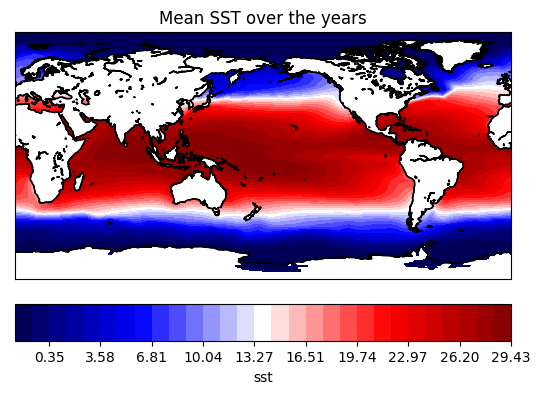

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_map(
    "Mean SST over the years",
    lon, lat,
    np.mean(sst, axis=0)
)


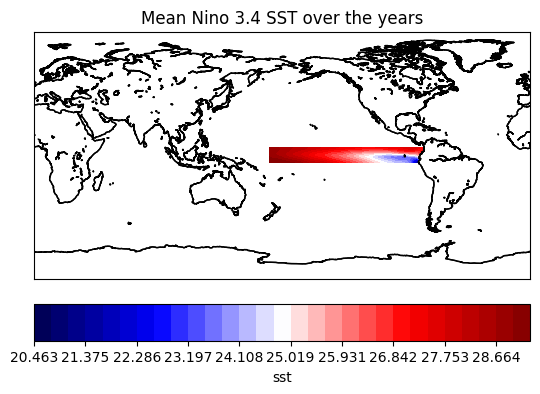

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the mean sst over the years for the selected region on Basemap
plot_map(
    "Mean Nino 3.4 SST over the years",
    lon[170:290], lat[84:96],
    np.mean(sst[:, 84:96, 170:290], axis=0)
)


# Preprocessing

In [4]:
# SST anomaly for the Nino 3.4 region
nino_3_4_sst = sst[:, 84:96, 170:290]
nino_3_4_sst_anomaly = nino_3_4_sst - nino_3_4_sst.mean()


In [5]:
# Mean Monthly Anomaly
mean_nino_3_4_sst_anomaly_monthly = np.mean(nino_3_4_sst_anomaly, axis=(1, 2))

# Mean Yearly Anomaly
n_months = mean_nino_3_4_sst_anomaly_monthly.shape[0]
mean_nino_3_4_sst_anomaly_yearly = np.split(
    mean_nino_3_4_sst_anomaly_monthly[:0-n_months % 12],
    n_months//12,
)
mean_nino_3_4_sst_anomaly_yearly = [
    year.mean() for year in mean_nino_3_4_sst_anomaly_yearly]
mean_nino_3_4_sst_anomaly_yearly = np.array(mean_nino_3_4_sst_anomaly_yearly)

# Mean 3 monthly Anomaly
mean_nino_3_4_sst_anomaly_trimonthly = np.split(
    mean_nino_3_4_sst_anomaly_monthly[:0-n_months % 3],
    n_months//3,
)
mean_nino_3_4_sst_anomaly_trimonthly = [
    tri.mean() for tri in mean_nino_3_4_sst_anomaly_trimonthly]
mean_nino_3_4_sst_anomaly_trimonthly = np.array(
    mean_nino_3_4_sst_anomaly_trimonthly)


C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_17468\3968308783.py:21: UserWarning: Warning: converting a masked element to nan.
  mean_nino_3_4_sst_anomaly_trimonthly = np.array(


In [6]:
print(mean_nino_3_4_sst_anomaly_monthly.shape)
print(mean_nino_3_4_sst_anomaly_trimonthly.shape)
print(mean_nino_3_4_sst_anomaly_yearly.shape)


(1587,)
(529,)
(132,)


### Visualising averaged SST Anomaly

Text(0.5, 1.0, 'Montly Mean Nino 3.4 SST anomaly')

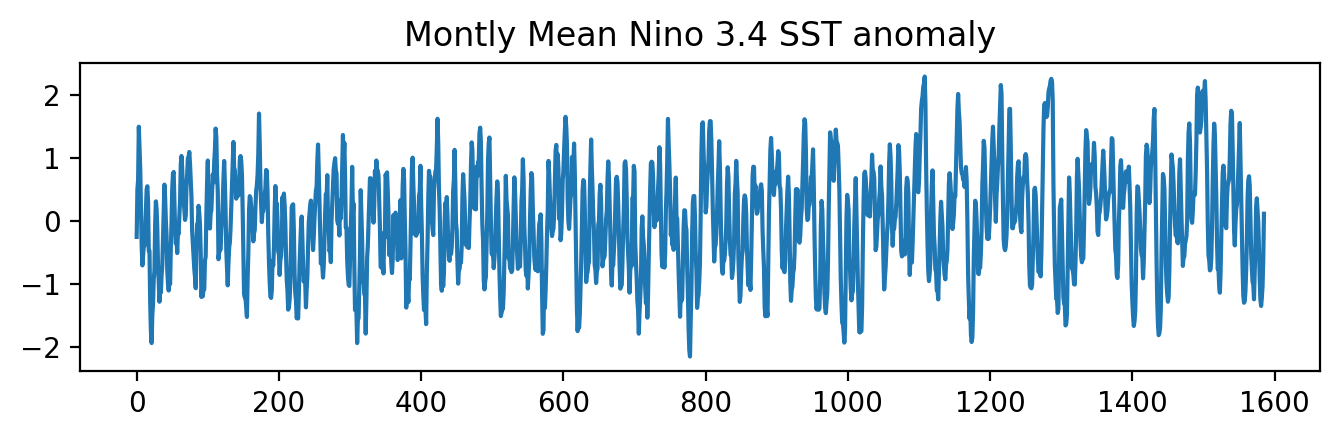

In [ ]:
plt.figure(figsize=(8, 2), dpi=200)
plt.plot(mean_nino_3_4_sst_anomaly_monthly)
plt.title("Montly Mean Nino 3.4 SST anomaly")


Text(0.5, 1.0, '3-Monthly Mean Nino 3.4 SST anomaly')

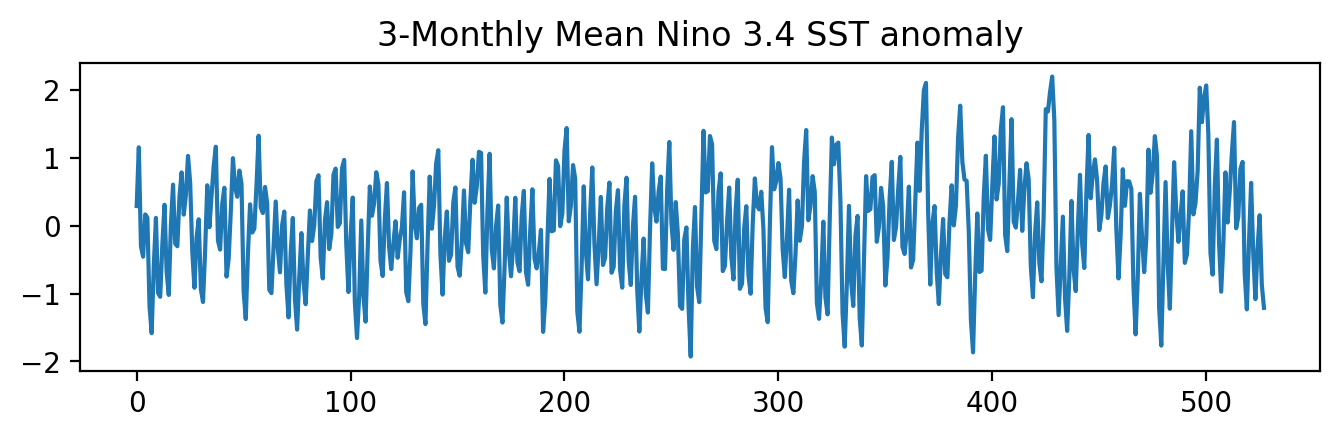

In [ ]:
plt.figure(figsize=(8, 2), dpi=200)
plt.plot(mean_nino_3_4_sst_anomaly_trimonthly)
plt.title("3-Monthly Mean Nino 3.4 SST anomaly")


Text(0.5, 1.0, 'Annual Mean Nino 3.4 SST anomaly')

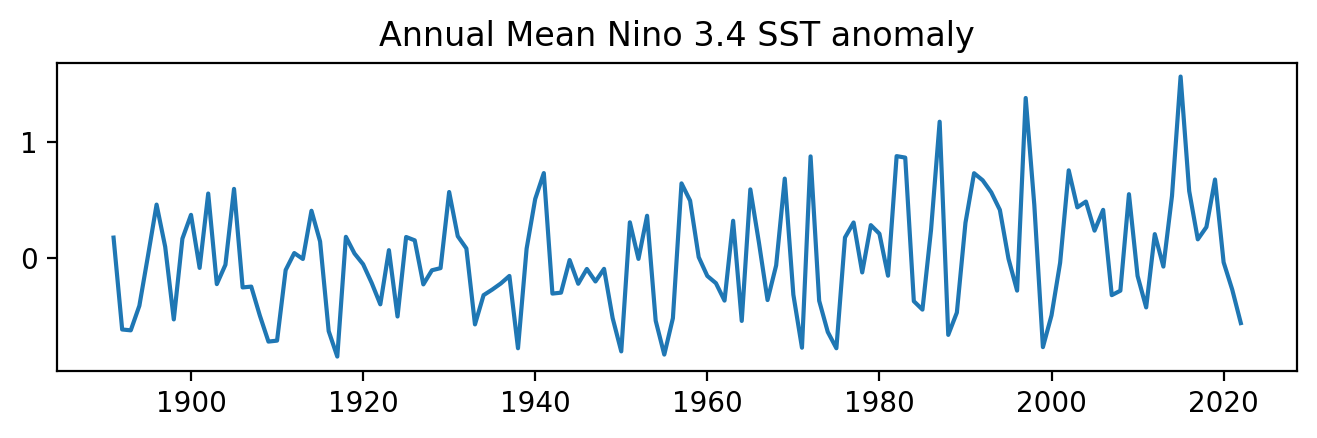

In [ ]:
plt.figure(figsize=(8, 2), dpi=200)
sns.lineplot(
    x=range(1891, 1891+mean_nino_3_4_sst_anomaly_yearly.size),
    y=mean_nino_3_4_sst_anomaly_yearly
)
plt.title("Annual Mean Nino 3.4 SST anomaly")


# Training

In [7]:
def prepare_model_input(data):
    ENSO_label = []
    dim = data.shape
    # mean_sst_anomaly_yearly = np.split(data[:0-dim[0] % 12], dim[0]//12, axis=0)
    # mean_sst_anomaly_yearly = [np.mean(a, axis=0)
    #                            for a in mean_sst_anomaly_yearly]
    # mean_sst_anomaly_yearly = np.stack(mean_sst_anomaly_yearly)

    # mean_sst_anomaly_yearly_flattened = mean_sst_anomaly_yearly.reshape(
    #     (dim[0]//12, -1))
    sst_anomaly_trimonthly = data - data.mean()
    sst_anomaly_trimonthly = np.split(data[:0-dim[0] % 3], dim[0]//3, axis=0)
    sst_anomaly_trimonthly = [np.mean(tri, axis=0)
                              for tri in sst_anomaly_trimonthly]
    sst_anomaly_trimonthly = np.stack(sst_anomaly_trimonthly)

    sst_anomaly_trimontly_flat = np.reshape(
        sst_anomaly_trimonthly,
        (dim[0]//3, -1)
    )

    for i in mean_nino_3_4_sst_anomaly_trimonthly:
        if i > 0:
            ENSO_label.append('El-nino')
        else:
            ENSO_label.append('La-nina')

    # return (mean_sst_anomaly_yearly, np.array(ENSO_label))
    return (sst_anomaly_trimontly_flat, np.array(ENSO_label))


### Preparing the Training and Testing Data

In [8]:
X, y = prepare_model_input(sst)


In [9]:
print(X.shape)
print(y.shape)


(529, 64800)
(529,)


In [10]:
import numpy.ma as ma
X = ma.getdata(X)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

enso_train, y_train_idx = np.unique(y_train, return_inverse=True)
enso_test, y_test_idx = np.unique(y_test, return_inverse=True)


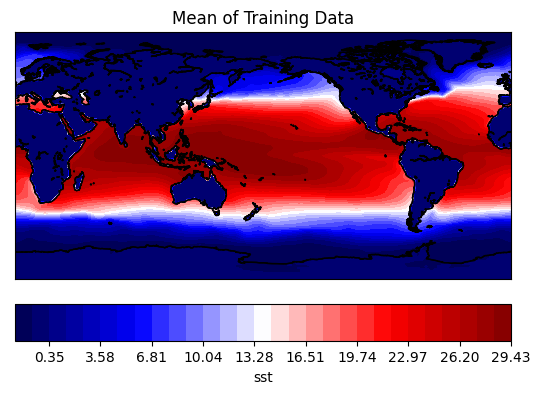

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot mean training and testing set on map
plot_map(
    "Mean of Training Data",
    lon, lat,
    np.mean(X_train.reshape((X_train.shape[0], 180, 360)), axis=0)
)


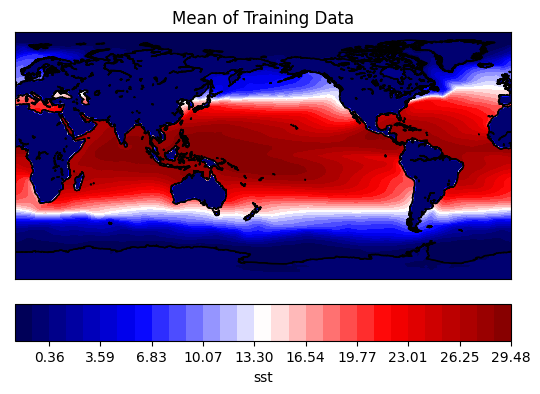

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_map(
    "Mean of Training Data",
    lon, lat,
    np.mean(X_test.reshape((X_test.shape[0], 180, 360)), axis=0)
)


In [12]:
X_train.shape


(352, 64800)

### Implementing PCA

In [13]:
from sklearn.decomposition import PCA

In [14]:
n_pca = 300
pca = PCA(n_components=n_pca).fit(X_train)


C:\Users\Anirvan Krishna\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [15]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [16]:
X_train_pca.shape

(352, 300)

In [17]:
# Create a device variable which will be used to shift model and data to GPU if available
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [18]:
import torch.nn as nn

In [19]:
class ANeuralNet(nn.Module):
    def __init__(self, in_size: int, layers: list, out_size: int) -> None:
        super().__init__()

        all_layers = []
        n = in_size
        for i in layers:
            all_layers.append(nn.Linear(n, i))
            all_layers.append(nn.ReLU(inplace=True))
            n = i
        all_layers.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.layers(x)



In [20]:
def prepare_batch(b_size):
    from torch.utils.data import TensorDataset, DataLoader

    X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

    dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
    dataset_test = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset_train, batch_size=b_size, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=b_size, shuffle=False)

    return (train_loader, test_loader)


def trainning_session(epochs: int, batch_size: int, lr: float, optim):
    torch.manual_seed(0)
    model = ANeuralNet(n_pca, [100, 80, 40, 20, 10], 2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    n = X_train_pca.shape[0]
    e = epochs
    train_loader, test_loader = prepare_batch(batch_size)
    n1 = X_test_pca.shape[0]
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []

    for i in range(e):
        trn_corr = 0
        tst_corr = 0

        for b, (X_train, y_train) in enumerate(train_loader):
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy.append(trn_corr*100/n)

        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                y_val = model(X_test)
                predicted = torch.max(y_val.data, 1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss.item())
        test_accuracy.append(tst_corr*100/n1)

        print(
             f'epoch: {i+1}\ttrain loss: {train_losses[i]:.3f} \ttrain accuracy: {train_accuracy[i]:2.3f}%')
        print(
             f"\t\ttest loss:  {test_losses[i]:.3f} \ttest accuracy:  {test_accuracy[i]:2.3f}%\n")

    
    #print(f"For batch size: {batch_size}\tlearning rate: {lr}\toptimizer: {optim} \ttest accuracy:  {test_accuracy[-1]:2.3f}%\n")

    return (model, train_losses, test_losses, train_accuracy, test_accuracy)


### Traning the NN

In [22]:
model, train_losses, test_losses, train_accuracy, test_accuracy = trainning_session(
    epochs=20,
    batch_size=100,
    lr=0.01,
    optim=torch.optim.SGD
)


epoch: 1	train loss: 0.711 	train accuracy: 0.000%
		test loss:  0.705 	test accuracy:  0.000%

epoch: 2	train loss: 0.688 	train accuracy: 14.773%
		test loss:  0.682 	test accuracy:  100.000%

epoch: 3	train loss: 0.665 	train accuracy: 100.000%
		test loss:  0.660 	test accuracy:  100.000%

epoch: 4	train loss: 0.643 	train accuracy: 100.000%
		test loss:  0.638 	test accuracy:  100.000%

epoch: 5	train loss: 0.623 	train accuracy: 100.000%
		test loss:  0.617 	test accuracy:  100.000%

epoch: 6	train loss: 0.603 	train accuracy: 100.000%
		test loss:  0.598 	test accuracy:  100.000%

epoch: 7	train loss: 0.583 	train accuracy: 100.000%
		test loss:  0.579 	test accuracy:  100.000%

epoch: 8	train loss: 0.565 	train accuracy: 100.000%
		test loss:  0.561 	test accuracy:  100.000%

epoch: 9	train loss: 0.547 	train accuracy: 100.000%
		test loss:  0.543 	test accuracy:  100.000%

epoch: 10	train loss: 0.531 	train accuracy: 100.000%
		test loss:  0.526 	test accuracy:  100.000%

epoc

# Results

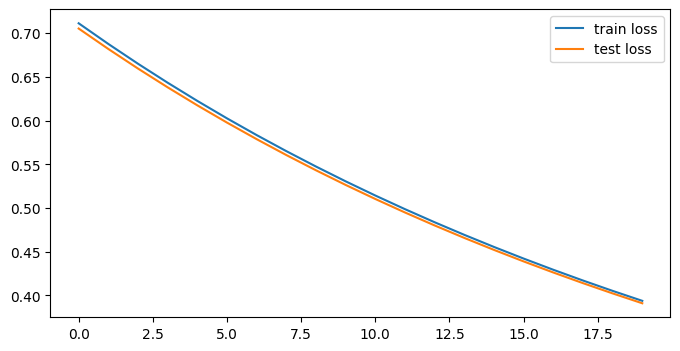

In [23]:
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["train loss", "test loss"])


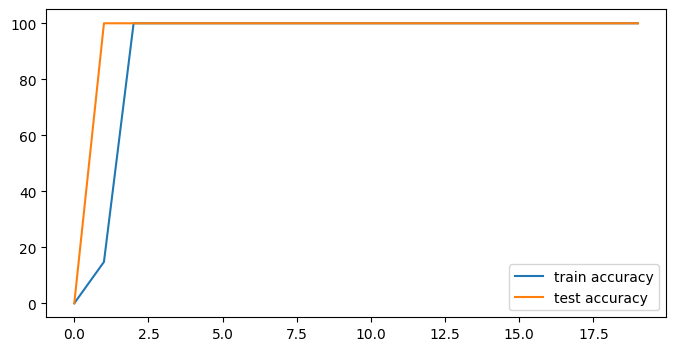

In [24]:
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.legend(["train accuracy", "test accuracy"])